In [546]:
import numpy as np
#import cupy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.signal import spectrogram, lfilter, freqz, tf2zpk, ellipord, ellip, find_peaks
import soundfile as sf
from IPython.display import Audio
from IPython.display import display

In [547]:
# xgerge01

SELECTED_MIDI = [40, 65, 82]                    # selected tones
SELECTED_MIDI_FREQ = [82.41, 349.23, 932.33]    # selected tones frequencies

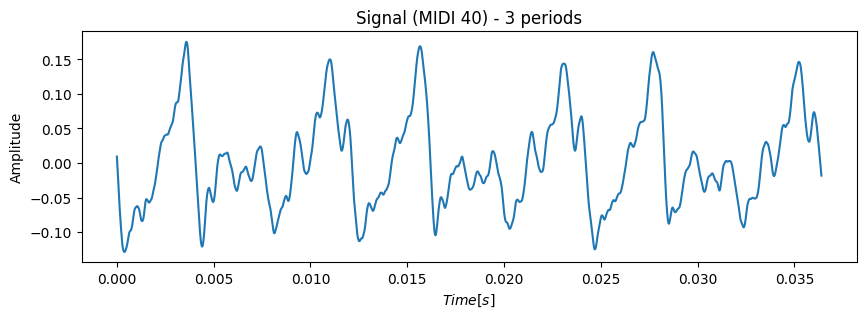

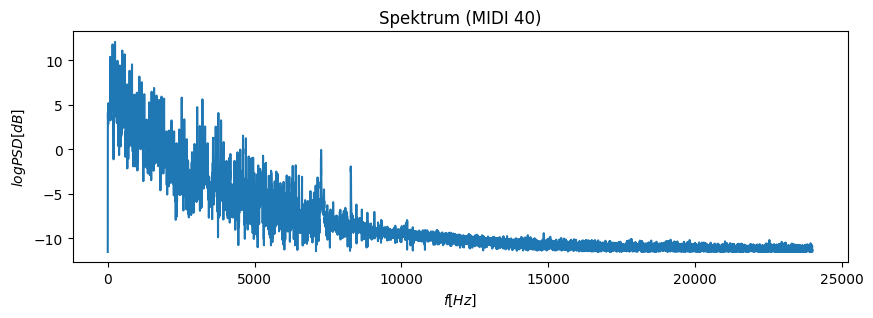

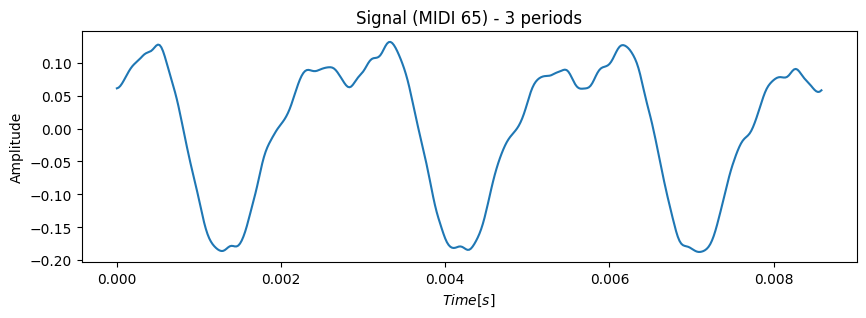

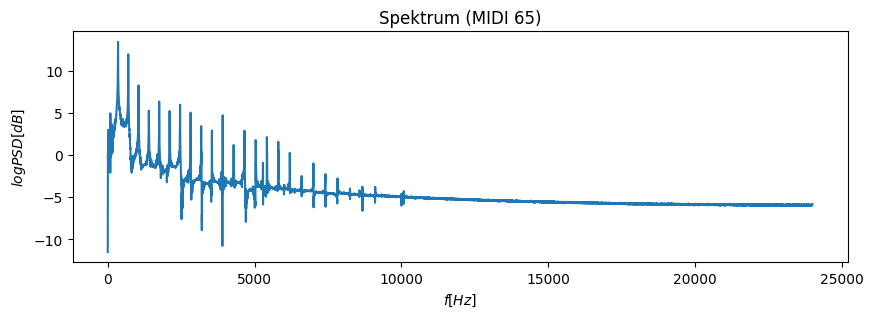

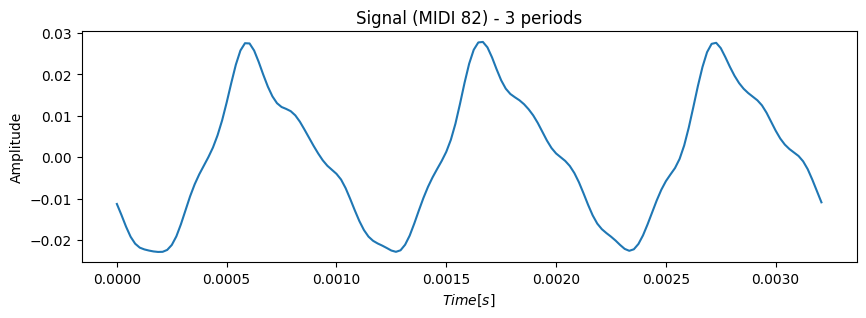

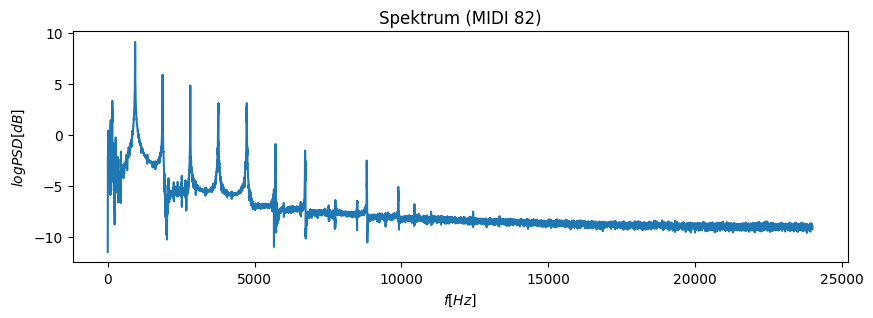

In [548]:
#  4.1 Základy

MIDIFROM = 24
MIDITO = 108

SKIP_SEC = 0.25
HOWMUCH_SEC = 0.5
WHOLETONE_SEC = 2

howmanytones = MIDITO - MIDIFROM + 1    # tone count
tones = np.arange(MIDIFROM, MIDITO+1)   # 24-108

s, Fs = sf.read('klavir.wav')           # read sound file

N = int(Fs * HOWMUCH_SEC)               # sample count for selected part of tone
Nwholetone = int(Fs * WHOLETONE_SEC)    # sample count for whole tone

xall = np.zeros((MIDITO+1, N))          # matrix (109 tones x 24000 samples) with all tones - first signals empty,
                                        # but we have plenty of memory ...
                             
samplefrom = int(SKIP_SEC * Fs)         # first tone to start from
sampleto = samplefrom + N               # first tone to end with

for tone in tones:
    x = s[samplefrom:sampleto]          # select part of tone
    x = x - np.mean(x)                  # safer to center ...
    xall[tone,:] = x                    # save tone to matrix

    samplefrom += Nwholetone            # next tone
    sampleto += Nwholetone              # next tone

tone_name_start = 'a'                   # selected tones start name
for i in range(len(SELECTED_MIDI)):
    tone_name = chr(ord(tone_name_start) + i)

    # save orig tone
    #display(Audio(xall[SELECTED_MIDI[i]], rate=Fs))
    sf.write('audio/%c_orig.wav' % tone_name, xall[SELECTED_MIDI[i]], Fs)

    # plot periods of tone
    num_periods = 3
    tone_period = Fs / SELECTED_MIDI_FREQ[i]
    time_steps = np.arange(0,num_periods*tone_period/Fs,step=1/Fs)
    plt.figure(figsize=(10, 3))
    plt.title('Signal (MIDI %d) - %d periods' % (SELECTED_MIDI[i], num_periods))
    plt.plot(time_steps, xall[SELECTED_MIDI[i]][:time_steps.size])
    plt.ylabel('Amplitude')
    plt.xlabel('$Time[s]$')
    plt.show()

    # dft
    X = np.fft.fft(xall[SELECTED_MIDI[i]])
    kall = np.arange(0, int(N/2) + 1)   # 0..N/2 
    Xmag = np.abs(X[kall])                        
    f = kall / N * Fs 

    spect = np.log(1e-5+Xmag**2)        # log PSD , +1e-5 to avoid log(0)

    # plot analysis
    plt.figure(figsize=(10,3))
    plt.title('Spektrum (MIDI %d)' % SELECTED_MIDI[i])
    plt.plot(f, spect)
    plt.ylabel('$logPSD[dB]$')
    plt.xlabel('$f[Hz]$')
    plt.show()

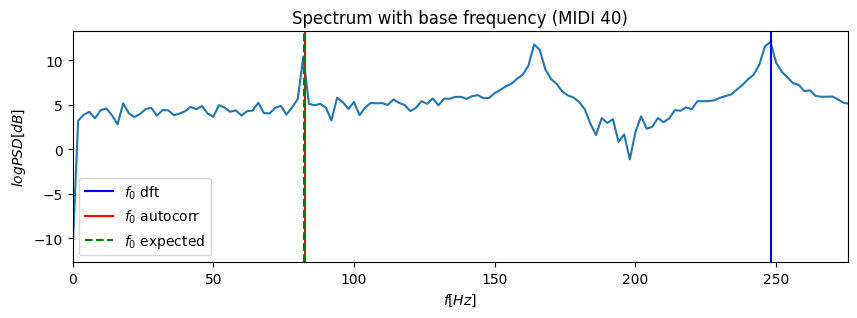

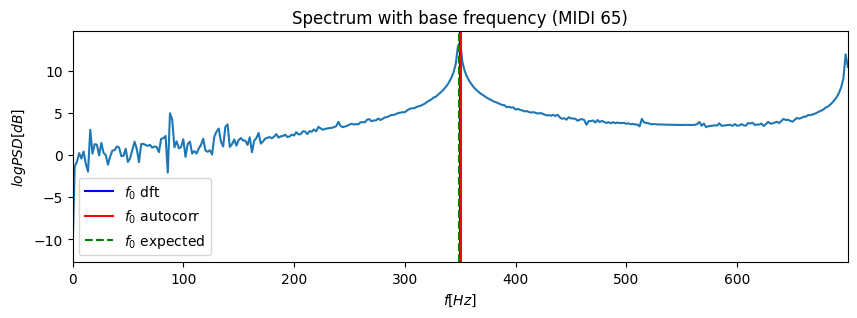

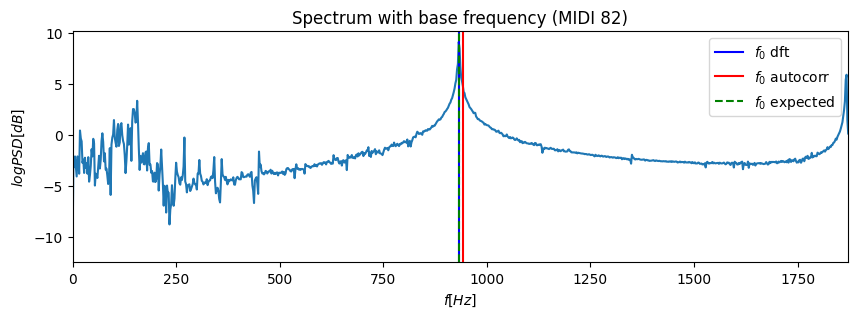

In [549]:
# 4.2 Určení základní frekvence

# load midi (expected) base frequencies from file
file_data = np.loadtxt('midi.txt')
file_data = file_data[:,1][::-1]
midi_fmax_orig = np.zeros(MIDITO+1)
midi_fmax_orig[MIDIFROM:MIDITO+1] = file_data

# get base frequency of MIDI tone with DFT and autocorrelation
midi_fmax_dft = np.zeros(MIDITO+1)
midi_fmax_ac = np.zeros(MIDITO+1)
for tone in tones:

    # dft
    X = np.fft.fft(xall[tone])
    kall = np.arange(0, int(N/2) + 1)   # 0..N/2
    Xmag = np.abs(X[kall])                        
    f = kall / N * Fs                   # kall -> fnorm -> f

    # find max
    midi_fmax_dft[tone] = f[np.argmax(Xmag)]

    # autocorrelation
    Rk = np.correlate(xall[tone], xall[tone], mode='full') / N
    Rk = Rk[Rk.size//2:]  # take only positive part

    # filter
    threshold = np.max(Rk) * 0.9
    Rk_filtered = np.where(Rk > threshold, Rk, 0)

    # first max peak is always at 0
    first_max_idx = np.argmax(Rk_filtered)

    # second max peak is first from found peaks
    peaks, _ = find_peaks(Rk_filtered)
    second_max_idx = peaks[0]

    period = second_max_idx - first_max_idx
    midi_fmax_ac[tone] = Fs / (period)

    # plt.figure(figsize=(10,3))
    # plt.title('Autokorelace (MIDI %d)' % tone)
    # plt.plot(Rk)
    # plt.plot(Rk_filtered, 'r--')
    # #plt.plot(peaks, Rk[peaks], "o")
    # plt.plot(first_max_idx, Rk[first_max_idx], 'ro')
    # plt.plot(second_max_idx, Rk[second_max_idx], 'go')
    # plt.ylabel('$R[k]$')
    # plt.xlabel('$k$')
    # plt.show()

    # plot my tones
    if tone in SELECTED_MIDI:
        
        spect = np.log(1e-5+Xmag**2)        # log PSD , +1e-5 to avoid log(0)

        # average of all frequencies
        freq_avg = np.mean([midi_fmax_dft[tone], midi_fmax_ac[tone], midi_fmax_orig[tone]])

        plt.figure(figsize=(10,3))
        plt.title('Spectrum with base frequency (MIDI %d)' % tone)
        plt.plot(f, spect)
        plt.axvline(midi_fmax_dft[tone], color='blue', linestyle='-', label='$f_0$ dft')
        plt.axvline(midi_fmax_ac[tone], color='red', linestyle='-', label='$f_0$ autocorr')
        plt.axvline(midi_fmax_orig[tone], color='green', linestyle='--', label='$f_0$ expected')
        plt.legend()
        plt.xlim([0,2*freq_avg])
        plt.ylabel('$logPSD[dB]$')
        plt.xlabel('$f[Hz]$')
        plt.show()

In [550]:
#print all calculated base frequencies
for tone in tones:
    print('MIDI %d:\t %.2f Hz (expected),  %.2f Hz (DFT),  %.2f Hz (autocorr)' % (tone, midi_fmax_orig[tone], midi_fmax_dft[tone], midi_fmax_ac[tone]))

# plt.figure(figsize=(10,3))
# plt.title('Base frequencies from DFT and autocorrelation')
# plt.xlim([MIDIFROM, MIDITO])
# plt.plot(midi_fmax_dft, 'b')
# plt.plot(midi_fmax_ac, 'g')
# plt.plot(midi_fmax_orig, 'r--')
# plt.legend(['dft', 'autocorr', 'expected'])
# plt.ylabel('$f[Hz]$')
# plt.xlabel('$MIDI$')
# plt.show()

MIDI 24:	 32.70 Hz (expected),  66.00 Hz (DFT),  32.81 Hz (autocorr)
MIDI 25:	 34.65 Hz (expected),  70.00 Hz (DFT),  34.76 Hz (autocorr)
MIDI 26:	 36.71 Hz (expected),  74.00 Hz (DFT),  36.84 Hz (autocorr)
MIDI 27:	 38.89 Hz (expected),  78.00 Hz (DFT),  39.02 Hz (autocorr)
MIDI 28:	 41.20 Hz (expected),  82.00 Hz (DFT),  41.34 Hz (autocorr)
MIDI 29:	 43.65 Hz (expected),  88.00 Hz (DFT),  43.80 Hz (autocorr)
MIDI 30:	 46.25 Hz (expected),  92.00 Hz (DFT),  46.42 Hz (autocorr)
MIDI 31:	 49.00 Hz (expected),  98.00 Hz (DFT),  49.18 Hz (autocorr)
MIDI 32:	 51.91 Hz (expected),  104.00 Hz (DFT),  52.12 Hz (autocorr)
MIDI 33:	 55.00 Hz (expected),  110.00 Hz (DFT),  55.17 Hz (autocorr)
MIDI 34:	 58.27 Hz (expected),  116.00 Hz (DFT),  58.47 Hz (autocorr)
MIDI 35:	 61.74 Hz (expected),  124.00 Hz (DFT),  61.94 Hz (autocorr)
MIDI 36:	 65.41 Hz (expected),  130.00 Hz (DFT),  65.57 Hz (autocorr)
MIDI 37:	 69.30 Hz (expected),  138.00 Hz (DFT),  69.46 Hz (autocorr)
MIDI 38:	 73.42 Hz (expected

In [551]:
# 4.3 Zpřesnění odhadu základní frekvence

# constants for aproximation
CENTS = 100
FREQ_RANGE = 2**(CENTS/1200)
FREQ_POINTS = 200

midi_fmax_dtft = np.zeros(MIDITO+1)
for tone in tones:

    # window
    Nfft = 2*Fs
    Flimit = N
    w = np.hamming(N)
    xw = xall[tone] * w
    xpad = np.pad(xw, (0, Nfft - N), 'constant', constant_values=0)

    # dft
    Xpad = np.fft.fft(xpad)
    klimited = np.arange(0,int(Flimit/Fs*Nfft))
    XpadMag = np.abs(Xpad[klimited])
    flimited = klimited / Nfft * Fs

    # get base frequency from hamming windowed signal
    fmax = flimited[np.argmax(XpadMag)]        
    ffrom = fmax - FREQ_RANGE
    fto = fmax + FREQ_RANGE
    fsweep = np.linspace(ffrom, fto, FREQ_POINTS)

    # dtft 
    n = np.arange(0,N)
    A = np.zeros([FREQ_POINTS, N],dtype=complex)   
    for k in np.arange(0, FREQ_POINTS):
        A[k,:] = np.exp(-1j * 2 * np.pi * fsweep[k] / Fs * n)     # norm. omega = 2 * pi * f / Fs * n
    Xdtft = np.matmul(A,xall[tone].T)
    midi_fmax_dtft[tone] = fsweep[np.argmax(np.abs(Xdtft))]

    # NO HAMMING DTFT for comparison

    # # base frequency from previous step dft
    # fmax = midi_fmax_dft[tone]; 
    # ffrom = fmax - FREQ_RANGE
    # fto = fmax + FREQ_RANGE
    # fsweep_noham = np.linspace(ffrom, fto, FREQ_POINTS)

    # # dtft 
    # n = np.arange(0,N)
    # A = np.zeros([FREQ_POINTS, N],dtype=complex)   
    # for k in np.arange(0, FREQ_POINTS):
    #     A[k,:] = np.exp(-1j * 2 * np.pi * fsweep_noham[k] / Fs * n)     # norm. omega = 2 * pi * f / Fs * n
    # Xdtft_noham = np.matmul(A,xall[tone].T)
    # midi_fmax_dtft_noham = fsweep_noham[np.argmax(np.abs(Xdtft_noham))]

    # PLOT COMPARISON

    # plt.figure(figsize=(10,3)) 
    # plt.title('DTFT 100c (MIDI %d)' % tone)
    # plt.plot(fsweep,np.abs(Xdtft), 'b', label='hamming')
    # plt.plot(fsweep_noham,np.abs(Xdtft_noham), 'm', label='no hamming')
    # plt.axvline(midi_fmax_orig[tone], color='black', linestyle='--', label='expected')
    # plt.axvline(fmax, color='red', linestyle='--', label='dft (hamming)')
    # plt.axvline(midi_fmax_dtft[tone], color='blue', linestyle='--', label='dtft (hamming)')
    # plt.axvline(midi_fmax_ac[tone], color='green', linestyle='--', label='autocorr')
    # plt.axvline(midi_fmax_dft[tone], color='orange', linestyle='--', label='dft (no hamming)')
    # plt.axvline(midi_fmax_dtft_noham, color='magenta', linestyle='--', label='dtft (no hamming)')
    # plt.legend()
    # plt.gca().set_ylabel('$|X(e^{j\omega})|$')
    # plt.show()

    if tone < 38 or tone in [53, 54, 55] :
        midi_fmax_dtft[tone] = midi_fmax_dtft[tone] / 2
        fmax = fmax / 2
    elif tone < 41:
        midi_fmax_dtft[tone] = midi_fmax_dtft[tone] / 3
        fmax = fmax / 3

    #print('MIDI %d (%.2f)' % (tone, midi_fmax_orig[tone]), '%.2f' % fmax, '%.2f' % midi_fmax_dtft[tone])

In [552]:
#print all calculated base frequencies
for tone in tones:
    print('MIDI %d:\t %.2f Hz (expected),  %.2f Hz (DTFT),  %.2f Hz (diff)' % (tone, midi_fmax_orig[tone], midi_fmax_dtft[tone], abs(midi_fmax_orig[tone] - midi_fmax_dtft[tone])))

# plt.figure(figsize=(10,3))
# plt.title('Base frequencies from DFT and DTFT')
# plt.xlim([MIDIFROM, MIDITO])
# plt.plot(midi_fmax_dft, 'b')
# plt.plot(midi_fmax_ac, 'y')
# plt.plot(midi_fmax_dtft, 'g')
# plt.plot(midi_fmax_orig, 'r--')
# plt.legend(['dft', 'autocorr', 'dtft', 'expected'])
# plt.ylabel('$f[Hz]$')
# plt.xlabel('$MIDI$')
# plt.show()

MIDI 24:	 32.70 Hz (expected),  32.68 Hz (DTFT),  0.02 Hz (diff)
MIDI 25:	 34.65 Hz (expected),  34.62 Hz (DTFT),  0.03 Hz (diff)
MIDI 26:	 36.71 Hz (expected),  36.68 Hz (DTFT),  0.03 Hz (diff)
MIDI 27:	 38.89 Hz (expected),  38.87 Hz (DTFT),  0.02 Hz (diff)
MIDI 28:	 41.20 Hz (expected),  41.17 Hz (DTFT),  0.03 Hz (diff)
MIDI 29:	 43.65 Hz (expected),  43.63 Hz (DTFT),  0.02 Hz (diff)
MIDI 30:	 46.25 Hz (expected),  46.23 Hz (DTFT),  0.02 Hz (diff)
MIDI 31:	 49.00 Hz (expected),  48.97 Hz (DTFT),  0.03 Hz (diff)
MIDI 32:	 51.91 Hz (expected),  51.88 Hz (DTFT),  0.03 Hz (diff)
MIDI 33:	 55.00 Hz (expected),  54.97 Hz (DTFT),  0.03 Hz (diff)
MIDI 34:	 58.27 Hz (expected),  58.23 Hz (DTFT),  0.04 Hz (diff)
MIDI 35:	 61.74 Hz (expected),  61.65 Hz (DTFT),  0.09 Hz (diff)
MIDI 36:	 65.41 Hz (expected),  65.31 Hz (DTFT),  0.10 Hz (diff)
MIDI 37:	 69.30 Hz (expected),  69.19 Hz (DTFT),  0.11 Hz (diff)
MIDI 38:	 73.42 Hz (expected),  73.39 Hz (DTFT),  0.03 Hz (diff)
MIDI 39:	 77.78 Hz (expec

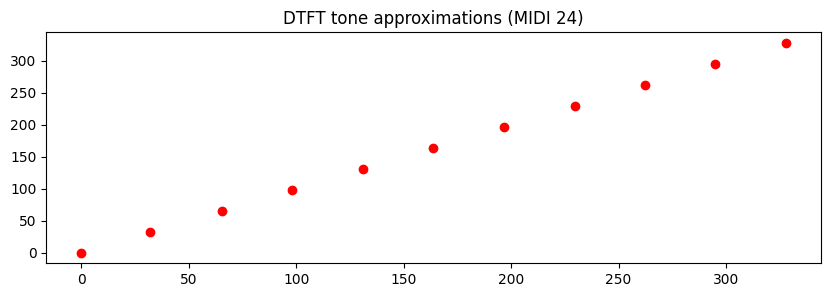

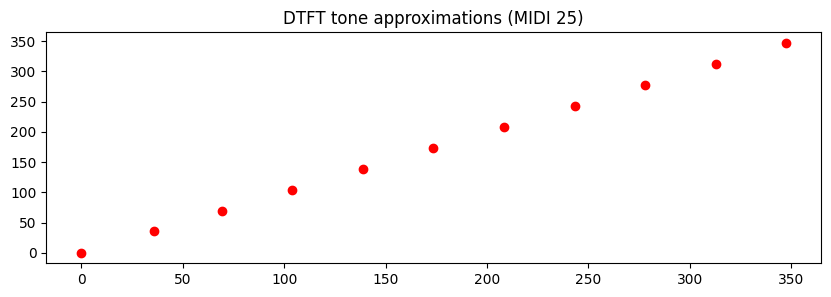

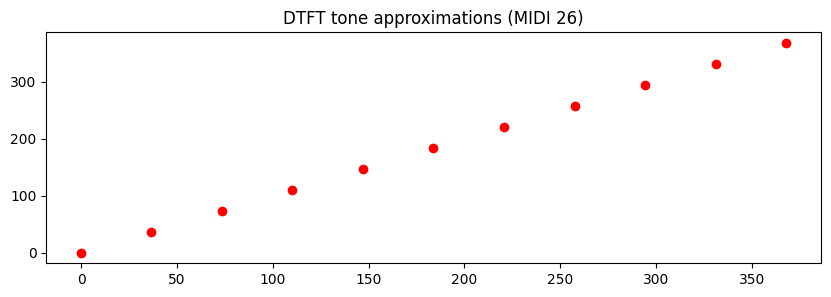

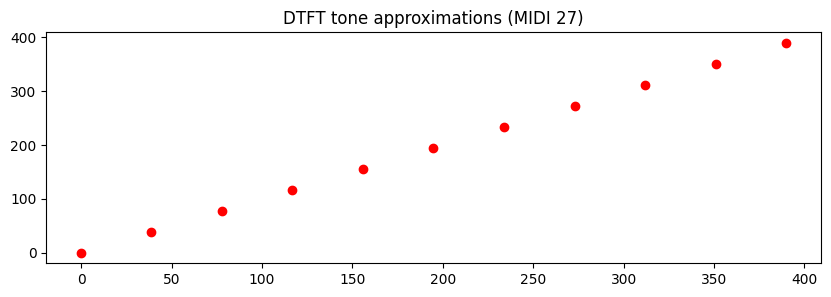

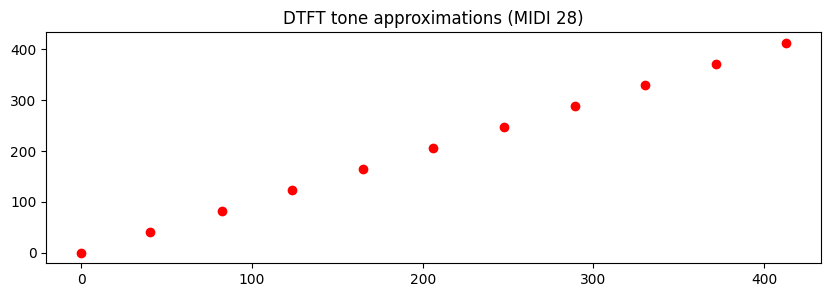

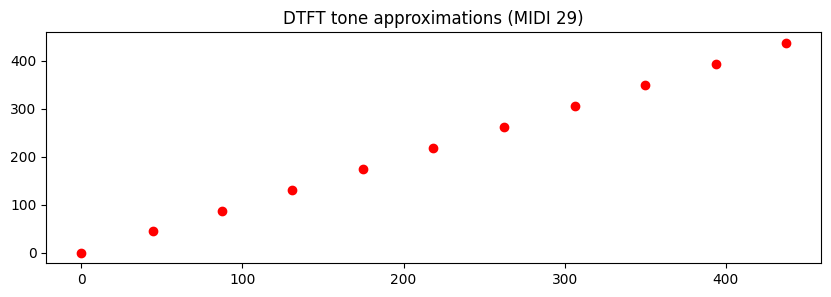

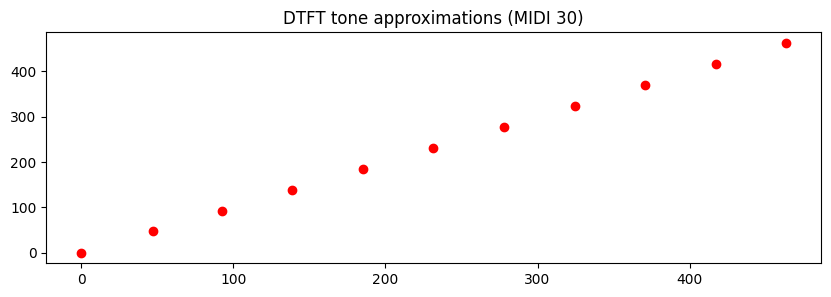

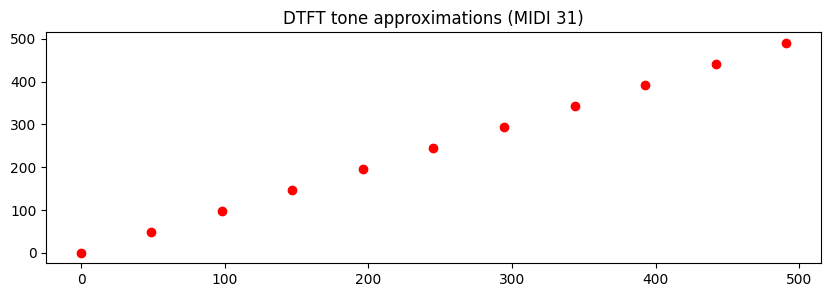

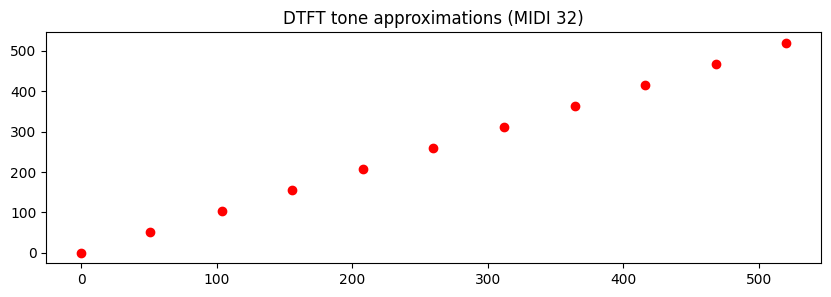

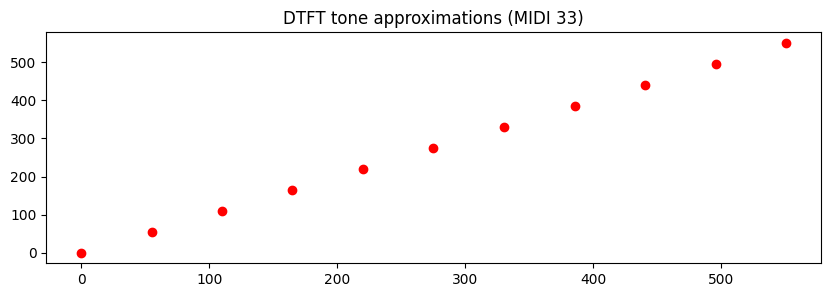

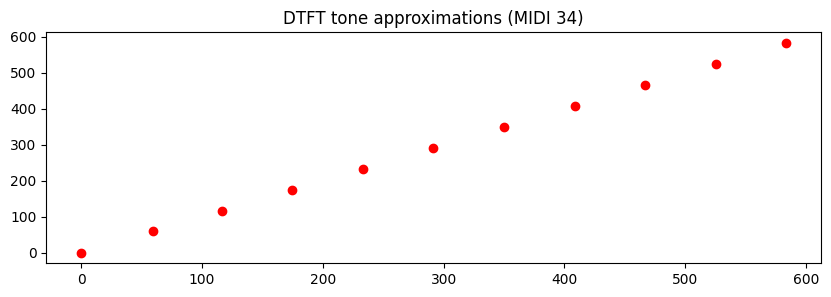

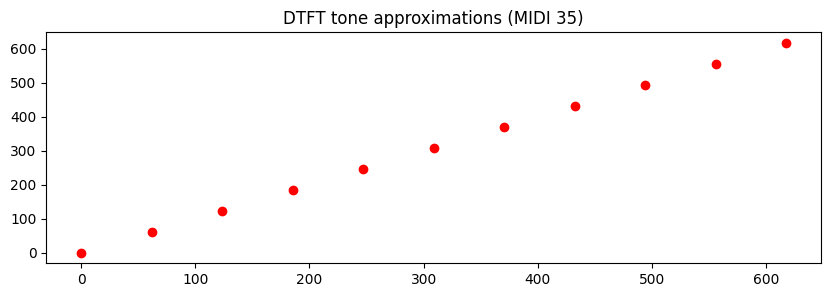

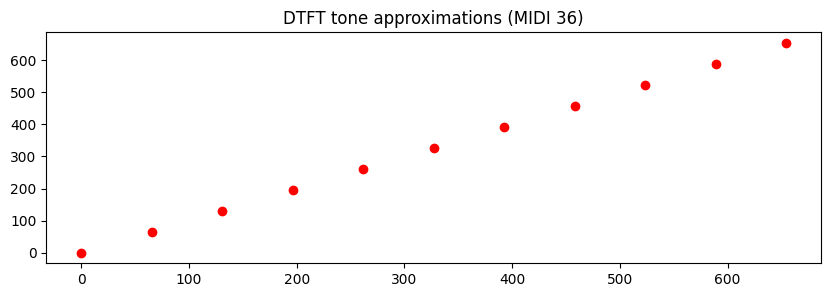

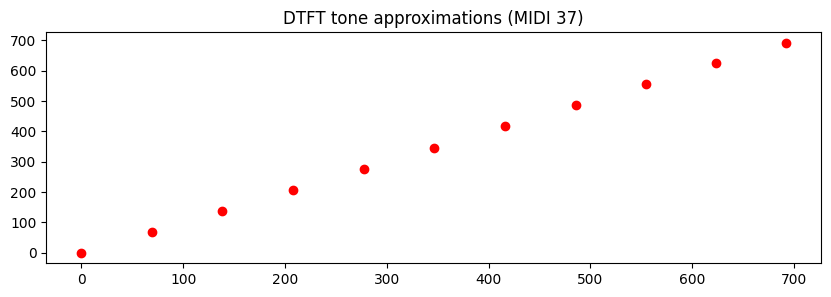

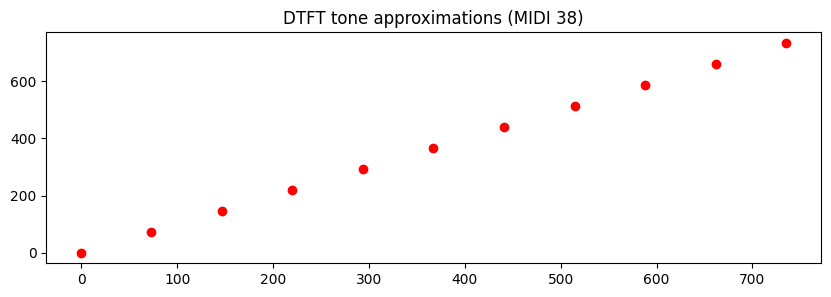

KeyboardInterrupt: 

In [553]:
# 4.4 Reprezentace klavíru

midi_dtft_freq = np.zeros((MIDITO+1, 11))
midi_dtft_mag = np.zeros((MIDITO+1, 11))
for tone in tones:

    for i in range(1, 11):

        # get base frequency from previous step (dtft)
        fmax = midi_fmax_dtft[tone] * i

        ffrom = fmax - FREQ_RANGE
        fto = fmax + FREQ_RANGE
        fsweep = np.linspace(ffrom, fto, FREQ_POINTS)

        # dtft 
        n = np.arange(0,N)
        A = np.zeros([FREQ_POINTS, N],dtype=complex)   
        for k in np.arange(0, FREQ_POINTS):
            A[k,:] = np.exp(-1j * 2 * np.pi * fsweep[k] / Fs * n)     # norm. omega = 2 * pi * f / Fs ... 
        Xdtft = np.matmul(A,xall[tone].T)

        midi_dtft_freq[tone][i] = fsweep[np.argmax(np.abs(Xdtft))]
        midi_dtft_mag[tone][i] = np.abs(midi_dtft_freq[tone][i])

    plt.figure(figsize=(10,3))
    plt.title('DTFT tone approximations (MIDI %d)' % tone)
    plt.plot(midi_dtft_freq[tone], midi_dtft_mag[tone], 'ro')
    plt.show()
    
    

In [ ]:

# tone_name_start = 'a'                   # selected tones start name
# for i in range(len(SELECTED_MIDI)):
#     tone_name = chr(ord(tone_name_start) + i)

#     # synthesis
#     xs = np.fft.ifft(X)
#     xs = np.real(xs)                # because of numerical computation ... 

#     # plot synthesis
#     plt.figure(figsize=(10,3))
#     plt.plot(xall[SELECTED_MIDI[i]])
#     plt.plot(xs)
#     plt.show()

#     # save synth tone
#     #display(Audio(xs, rate=Fs))
#     sf.write('audio/%c.wav' % tone_name, xs, Fs)

#     _, ax = plt.subplots(3,1, figsize=(10,6))
#     ax[0].plot(kall, Xmag)
#     ax[0].text(0.4*N, max(Xmag)/2, '$k$',fontsize=18)
#     fnorm = kall / N
#     ax[1].plot(fnorm, Xmag)
#     ax[1].text(0.4, max(Xmag)/2, '$f_{norm}$',fontsize=18)
#     f = fnorm * Fs
#     ax[2].plot(f, Xmag)
#     ax[2].text(0.4*Fs, max(Xmag)/2, '$f$ [Hz]',fontsize=18)
